# Style Transfer
在这个笔记本中，我们将实现样式转换技术 ["Image Style Transfer Using Convolutional Neural Networks" (Gatys et al., CVPR 2015)](http://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf).

总的思路是取两个图像，生成一个新的图像，反映其中一个的内容，但反映另一个的艺术“风格”。为此，我们将首先构造一个损失函数，该函数与深度网络特征空间中每个图像的内容和样式相匹配，然后对图像本身的像素进行梯度下降。

我们使用深度网络作为特征提取器[SqueezeNet](https://arxiv.org/abs/1602.07360),一个在ImageNet上训练过的小模型。你可以使用任何网络，但我们选择了SqueezeNet在这里，因为它的规模小，效率高。

这里有一个例子，你将能够产生的图像结束本笔记本:
![caption](example_styletransfer.png)


## Setup

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision
import torchvision.transforms as T
import PIL

import numpy as np

from scipy.misc import imread
from collections import namedtuple
import matplotlib.pyplot as plt

from cs231n.image_utils import SQUEEZENET_MEAN, SQUEEZENET_STD
%matplotlib inline

我们提供了一些帮助函数来处理图像，因为在这部分作业中，我们处理的是真正的jpeg，而不是CIFAR-10数据。

In [2]:
def preprocess(img, size=512):
    transform = T.Compose([
        T.Scale(size),
        T.ToTensor(),
        T.Normalize(mean=SQUEEZENET_MEAN.tolist(),
                    std=SQUEEZENET_STD.tolist()),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)

def deprocess(img):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=[1.0 / s for s in SQUEEZENET_STD.tolist()]),
        T.Normalize(mean=[-m for m in SQUEEZENET_MEAN.tolist()], std=[1, 1, 1]),
        T.Lambda(rescale),
        T.ToPILImage(),
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def features_from_img(imgpath, imgsize):
    img = preprocess(PIL.Image.open(imgpath), size=imgsize)
    img_var = Variable(img.type(dtype))
    return extract_features(img_var, cnn), img_var

# Older versions of scipy.misc.imresize yield different results
# from newer versions, so we check to make sure scipy is up to date.
def check_scipy():
    import scipy
    vnum = int(scipy.__version__.split('.')[1])
    major_vnum = int(scipy.__version__.split('.')[0])
    assert vnum >= 16 or major_vnum >= 1, "You must install SciPy >= 0.16.0 to complete this notebook."

check_scipy()

answers = np.load('style-transfer-checks.npz')


和上一个任务一样，我们需要设置dtype来选择CPU或GPU

In [3]:
dtype = torch.FloatTensor
# Uncomment out the following line if you're on a machine with a GPU set up for PyTorch!
# dtype = torch.cuda.FloatTensor 

In [4]:
# Load the pre-trained SqueezeNet model.
cnn = torchvision.models.squeezenet1_1(pretrained=True).features
cnn.type(dtype)

# We don't want to train the model any further, so we don't want PyTorch to waste computation 
# computing gradients on parameters we're never going to update.
for param in cnn.parameters():
    param.requires_grad = False

# We provide this helper code which takes an image, a model (cnn), and returns a list of
# feature maps, one per layer.
def extract_features(x, cnn):
    """
    Use the CNN to extract features from the input image x.
    
    Inputs:
    - x: A PyTorch Variable of shape (N, C, H, W) holding a minibatch of images that
      will be fed to the CNN.
    - cnn: A PyTorch model that we will use to extract features.
    
    Returns:
    - features: A list of feature for the input images x extracted using the cnn model.
      features[i] is a PyTorch Variable of shape (N, C_i, H_i, W_i); recall that features
      from different layers of the network may have different numbers of channels (C_i) and
      spatial dimensions (H_i, W_i).
    """
    features = []
    prev_feat = x
    for i, module in enumerate(cnn._modules.values()):
        next_feat = module(prev_feat)
        features.append(next_feat)
        prev_feat = next_feat
    return features

## 计算损失
我们现在要计算损失函数的三个分量。损失函数是三个术语的加权和:内容损失+风格损失+总变化损失。你将填写下面计算这些加权项的函数。

## Content loss
我们可以生成一个图像，反映一个图像的内容和另一个图像的风格，通过合并到我们的损失函数。我们想要处罚内容图像内容的偏离和样式图像样式的偏离。然后我们可以使用这个混合损失函数来执行梯度下降**不是对模型的参数**，而是对原始图像的像素值**。

Let's first write the content loss function. Content loss measures how much the feature map of the generated image differs from the feature map of the source image. We only care about the content representation of one layer of the network (say, layer $\ell$), that has feature maps $A^\ell \in \mathbb{R}^{1 \times C_\ell \times H_\ell \times W_\ell}$. $C_\ell$ is the number of filters/channels in layer $\ell$, $H_\ell$ and $W_\ell$ are the height and width. We will work with reshaped versions of these feature maps that combine all spatial positions into one dimension. Let $F^\ell \in \mathbb{R}^{N_\ell \times M_\ell}$ be the feature map for the current image and $P^\ell \in \mathbb{R}^{N_\ell \times M_\ell}$ be the feature map for the content source image where $M_\ell=H_\ell\times W_\ell$ is the number of elements in each feature map. Each row of $F^\ell$ or $P^\ell$ represents the vectorized activations of a particular filter, convolved over all positions of the image. Finally, let $w_c$ be the weight of the content loss term in the loss function.

Then the content loss is given by:

$L_c = w_c \times \sum_{i,j} (F_{ij}^{\ell} - P_{ij}^{\ell})^2$

In [5]:
def content_loss(content_weight, content_current, content_original):
    """
    Compute the content loss for style transfer.
    
    Inputs:
    - content_weight: Scalar giving the weighting for the content loss.
    - content_current: features of the current image; this is a PyTorch Tensor of shape
      (1, C_l, H_l, W_l).
    - content_target: features of the content image, Tensor with shape (1, C_l, H_l, W_l).
    
    Returns:
    - scalar content loss
    """
    return (content_current-content_original).pow(2).sum()*content_weight


测试您的内容损失。误差应该小于0.001。

In [6]:
def content_loss_test(correct):
    content_image = 'styles/tubingen.jpg'
    image_size =  192
    content_layer = 3
    content_weight = 6e-2
    
    c_feats, content_img_var = features_from_img(content_image, image_size)
    
    bad_img = torch.zeros(*content_img_var.data.size()).type(dtype)
    feats = extract_features(bad_img, cnn)
    
    student_output = content_loss(content_weight, c_feats[content_layer], feats[content_layer]).cpu().data.numpy()
    error = rel_error(correct, student_output)
    print('Maximum error is {:.3f}'.format(error))

content_loss_test(answers['cl_out'])

Maximum error is 0.000


D:\Anaconda3\lib\site-packages\torchvision\transforms\transforms.py:210: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


## Style loss
现在我们可以处理风格的丢失。对于给定的层$\ell$，样式损失定义如下:
首先，计算代表每个滤波器响应之间相关性的Gram矩阵G，其中F如上所示。Gram矩阵是协方差矩阵的近似值——我们希望生成的图像的激活统计信息与样式图像的激活统计信息匹配，而匹配(近似)协方差是实现此目的的一种方法。有很多种方法可以做这个，但是克矩阵很好因为它很容易计算而且在实践中显示出很好的结果

Given a feature map $F^\ell$ of shape $(1, C_\ell, M_\ell)$, the Gram matrix has shape $(1, C_\ell, C_\ell)$ and its elements are given by:

$$G_{ij}^\ell  = \sum_k F^{\ell}_{ik} F^{\ell}_{jk}$$

Assuming $G^\ell$ is the Gram matrix from the feature map of the current image, $A^\ell$ is the Gram Matrix from the feature map of the source style image, and $w_\ell$ a scalar weight term, then the style loss for the layer $\ell$ is simply the weighted Euclidean distance between the two Gram matrices:

$$L_s^\ell = w_\ell \sum_{i, j} \left(G^\ell_{ij} - A^\ell_{ij}\right)^2$$

In practice we usually compute the style loss at a set of layers $\mathcal{L}$ rather than just a single layer $\ell$; then the total style loss is the sum of style losses at each layer:

$$L_s = \sum_{\ell \in \mathcal{L}} L_s^\ell$$

Begin by implementing the Gram matrix computation below:

In [7]:
def gram_matrix(features, normalize=True):
    """
    Compute the Gram matrix from features.
    
    Inputs:
    - features: PyTorch Variable of shape (N, C, H, W) giving features for
      a batch of N images.
    - normalize: optional, whether to normalize the Gram matrix
        If True, divide the Gram matrix by the number of neurons (H * W * C)
    
    Returns:
    - gram: PyTorch Variable of shape (N, C, C) giving the
      (optionally normalized) Gram matrices for the N input images.
    """
    N,C,H,W=features.shape
    features=features.reshape(N,C,-1)
    gram=features.new_zeros((N,C,C))
    for i in range(N):
        gram[i]+=features[i] @ (features[i].T)
    if normalize:
        gram/=H*W*C
    return gram

测试你的Gram矩阵代码。误差应该小于0.001。

In [8]:
def gram_matrix_test(correct):
    style_image = 'styles/starry_night.jpg'
    style_size = 192
    feats, _ = features_from_img(style_image, style_size)
    student_output = gram_matrix(feats[5].clone()).cpu().data.numpy()
    error = rel_error(correct, student_output)
    print('Maximum error is {:.3f}'.format(error))
    
gram_matrix_test(answers['gm_out'])

Maximum error is 0.000


接下来，实现样式损失：

In [9]:
# Now put it together in the style_loss function...
def style_loss(feats, style_layers, style_targets, style_weights):
    """
    Computes the style loss at a set of layers.
    
    Inputs:
    - feats: list of the features at every layer of the current image, as produced by
      the extract_features function.
    - style_layers: List of layer indices into feats giving the layers to include in the
      style loss.
    - style_targets: List of the same length as style_layers, where style_targets[i] is
      a PyTorch Variable giving the Gram matrix the source style image computed at
      layer style_layers[i].
    - style_weights: List of the same length as style_layers, where style_weights[i]
      is a scalar giving the weight for the style loss at layer style_layers[i].
      
    Returns:
    - style_loss: A PyTorch Variable holding a scalar giving the style loss.
    """
    # Hint: you can do this with one for loop over the style layers, and should
    # not be very much code (~5 lines). You will need to use your gram_matrix function.
    loss=feats[0].new_zeros((1))
    for i in range(len(style_weights)):
        t=gram_matrix(feats[style_layers[i]])
        loss+=style_weights[i]*torch.sum((t-style_targets[i])**2)
    return loss


测试您的样式损失实现。误差应小于0.001。

In [10]:
def style_loss_test(correct):
    content_image = 'styles/tubingen.jpg'
    style_image = 'styles/starry_night.jpg'
    image_size =  192
    style_size = 192
    style_layers = [1, 4, 6, 7]
    style_weights = [300000, 1000, 15, 3]
    
    c_feats, _ = features_from_img(content_image, image_size)
    feats, _ = features_from_img(style_image, style_size)
    style_targets = []
    for idx in style_layers:
        style_targets.append(gram_matrix(feats[idx].clone()))
    
    student_output = style_loss(c_feats, style_layers, style_targets, style_weights).cpu().data.numpy()
    error = rel_error(correct, student_output)
    print('Error is {:.3f}'.format(error))

    
style_loss_test(answers['sl_out'])

Error is 0.000


## Total-variation regularization
事实证明，它也有助于促进图像的平滑。我们可以通过在损失中增加另一项来惩罚像素值的波动或“总变化”。

You can compute the "total variation" as the sum of the squares of differences in the pixel values for all pairs of pixels that are next to each other (horizontally or vertically). Here we sum the total-variation regualarization for each of the 3 input channels (RGB), and weight the total summed loss by the total variation weight, $w_t$:

$L_{tv} = w_t \times \sum_{c=1}^3\sum_{i=1}^{H-1} \sum_{j=1}^{W-1} \left( (x_{i,j+1, c} - x_{i,j,c})^2 + (x_{i+1, j,c} - x_{i,j,c})^2  \right)$

In the next cell, fill in the definition for the TV loss term. To receive full credit, your implementation should not have any loops.

In [11]:
def tv_loss(img, tv_weight):
    """
    Compute total variation loss.
    
    Inputs:
    - img: PyTorch Variable of shape (1, 3, H, W) holding an input image.
    - tv_weight: Scalar giving the weight w_t to use for the TV loss.
    
    Returns:
    - loss: PyTorch Variable holding a scalar giving the total variation loss
      for img weighted by tv_weight.
    """
    # Your implementation should be vectorized and not require any loops!
    return tv_weight*(torch.pow(img[:,:,1:]-img[:,:,:-1],2).sum()+torch.pow(img[:,:,:,1:]-img[:,:,:,:-1],2).sum())


测试你的TV损失实现。误差应小于0.001。

In [12]:
def tv_loss_test(correct):
    content_image = 'styles/tubingen.jpg'
    image_size =  192
    tv_weight = 2e-2

    content_img = preprocess(PIL.Image.open(content_image), size=image_size).type(dtype)
    
    student_output = tv_loss(content_img, tv_weight).cpu().data.numpy()
    error = rel_error(correct, student_output)
    print('Error is {:.3f}'.format(error))
    
tv_loss_test(answers['tv_out'])

Error is 0.000


现在我们准备好把它串在一起(你不应该修改这个函数):

In [13]:
def style_transfer(content_image, style_image, image_size, style_size, content_layer, content_weight,
                   style_layers, style_weights, tv_weight, init_random = False):
    """
    Run style transfer!
    
    Inputs:
    - content_image: filename of content image
    - style_image: filename of style image
    - image_size: size of smallest image dimension (used for content loss and generated image)
    - style_size: size of smallest style image dimension
    - content_layer: layer to use for content loss
    - content_weight: weighting on content loss
    - style_layers: list of layers to use for style loss
    - style_weights: list of weights to use for each layer in style_layers
    - tv_weight: weight of total variation regularization term
    - init_random: initialize the starting image to uniform random noise
    """
    
    # Extract features for the content image
    content_img = preprocess(PIL.Image.open(content_image), size=image_size)
    content_img_var = Variable(content_img.type(dtype))
    feats = extract_features(content_img_var, cnn)
    content_target = feats[content_layer].clone()

    # Extract features for the style image
    style_img = preprocess(PIL.Image.open(style_image), size=style_size)
    style_img_var = Variable(style_img.type(dtype))
    feats = extract_features(style_img_var, cnn)
    style_targets = []
    for idx in style_layers:
        style_targets.append(gram_matrix(feats[idx].clone()))

    # Initialize output image to content image or nois
    if init_random:
        img = torch.Tensor(content_img.size()).uniform_(0, 1)
    else:
        img = content_img.clone().type(dtype)

    # We do want the gradient computed on our image!
    img_var = Variable(img, requires_grad=True)

    # Set up optimization hyperparameters
    initial_lr = 3.0
    decayed_lr = 0.1
    decay_lr_at = 180

    # Note that we are optimizing the pixel values of the image by passing
    # in the img_var Torch variable, whose requires_grad flag is set to True
    optimizer = torch.optim.Adam([img_var], lr=initial_lr)
    
    f, axarr = plt.subplots(1,2)
    axarr[0].axis('off')
    axarr[1].axis('off')
    axarr[0].set_title('Content Source Img.')
    axarr[1].set_title('Style Source Img.')
    axarr[0].imshow(deprocess(content_img.cpu()))
    axarr[1].imshow(deprocess(style_img.cpu()))
    plt.show()
    plt.figure()
    
    for t in range(200):
        if t < 190:
            img.clamp_(-1.5, 1.5)
        optimizer.zero_grad()

        feats = extract_features(img_var, cnn)
        
        # Compute loss
        c_loss = content_loss(content_weight, feats[content_layer], content_target)
        s_loss = style_loss(feats, style_layers, style_targets, style_weights)
        t_loss = tv_loss(img_var, tv_weight) 
        loss = c_loss + s_loss + t_loss
        
        loss.backward()

        # Perform gradient descents on our image values
        if t == decay_lr_at:
            optimizer = torch.optim.Adam([img_var], lr=decayed_lr)
        optimizer.step()

        if t % 100 == 0:
            print('Iteration {}'.format(t))
            plt.axis('off')
            plt.imshow(deprocess(img.cpu()))
            plt.show()
    print('Iteration {}'.format(t))
    plt.axis('off')
    plt.imshow(deprocess(img.cpu()))
    plt.show()

## 生成一些漂亮的图片!
在下面三个不同的参数集上尝试' style_transfer '。确保运行所有三个单元格。您可以随意添加自己的样式，但是请确保在您提交的笔记本中包含第三个参数集(星夜)的样式转换结果。
* ' content_image '是内容图像的文件名。
* ' style_image '是style image的文件名。
* “image_size”是内容图像的最小图像维数(用于内容丢失和生成图像)。
* ' style_size '是图像中最小的样式尺寸。
* ' content_layer '指定用于内容丢失的层。
* ' content_weight '给出了总体损失函数中内容损失的权重。增加这个参数的值将使最终的图像看起来更真实(更接近原始内容)。
* ' style_layers '指定一个用于样式丢失的层列表。
* ' style_weights '指定了一个用于style_layers中每一层的权重列表(每一个都会导致一个术语的整体风格丢失)。我们通常对早期的样式层使用更高的权重，因为它们描述了更多的局部/更小的尺度特征，这对纹理来说比在更大的接受域上的特征更重要。一般来说，增加这些权重会使生成的图像看起来不太像原始内容，而更倾向于样式图像的外观。
* ' tv_weight '指定总波动正则化在总损失函数中的权重。增加这个值会使生成的图像看起来更平滑，锯齿更少，代价是对样式和内容的保真度降低。

在接下来的三个代码单元格(不应该在其中更改超参数)下面，您可以随意复制和粘贴参数，看看结果图像是如何变化的。

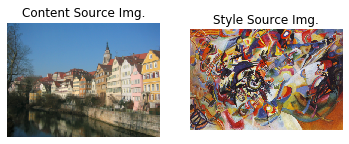

Iteration 0


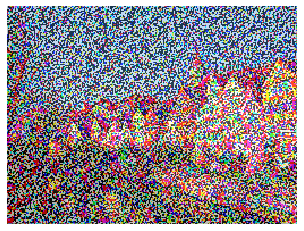

Iteration 100


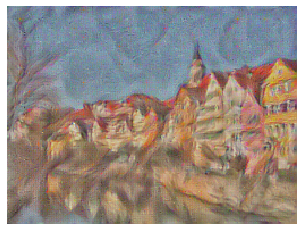

Iteration 199


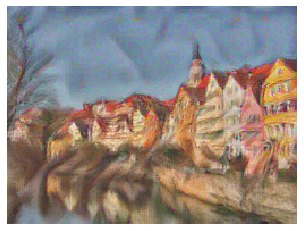

In [14]:
# Composition VII + Tubingen
params1 = {
    'content_image' : 'styles/tubingen.jpg',
    'style_image' : 'styles/composition_vii.jpg',
    'image_size' : 192,
    'style_size' : 512,
    'content_layer' : 3,
    'content_weight' : 5e-2, 
    'style_layers' : (1, 4, 6, 7),
    'style_weights' : (20000, 500, 12, 1),
    'tv_weight' : 5e-2
}

style_transfer(**params1)

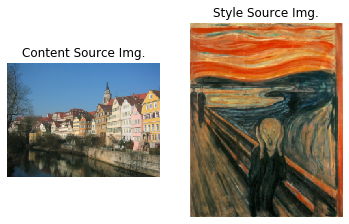

Iteration 0


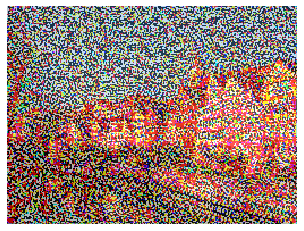

Iteration 100


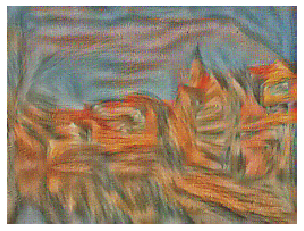

Iteration 199


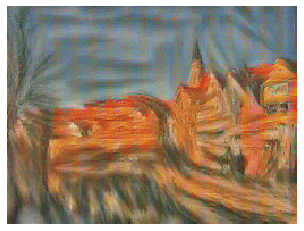

In [15]:
# Scream + Tubingen
params2 = {
    'content_image':'styles/tubingen.jpg',
    'style_image':'styles/the_scream.jpg',
    'image_size':192,
    'style_size':224,
    'content_layer':3,
    'content_weight':3e-2,
    'style_layers':[1, 4, 6, 7],
    'style_weights':[200000, 800, 12, 1],
    'tv_weight':2e-2
}

style_transfer(**params2)

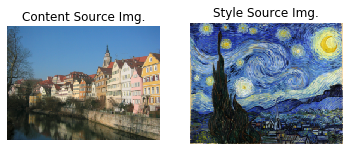

Iteration 0


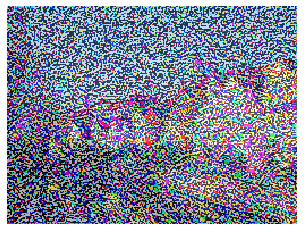

Iteration 100


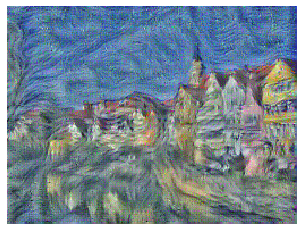

Iteration 199


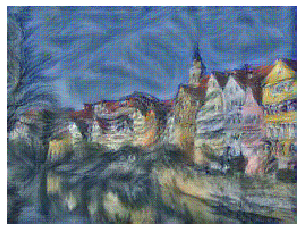

In [16]:
# Starry Night + Tubingen
params3 = {
    'content_image' : 'styles/tubingen.jpg',
    'style_image' : 'styles/starry_night.jpg',
    'image_size' : 192,
    'style_size' : 192,
    'content_layer' : 3,
    'content_weight' : 6e-2,
    'style_layers' : [1, 4, 6, 7],
    'style_weights' : [300000, 1000, 15, 3],
    'tv_weight' : 2e-2
}

style_transfer(**params3)

## Feature Inversion
您编写的代码可以做另一件很酷的事情。为了理解卷积网络学会识别的特征类型，最近的一篇论文[1]试图从特征表示重建图像。我们可以很容易地使用来自预训练网络的图像梯度来实现这个想法，这正是我们在上面所做的(但是使用了两种不同的特性表示)。
现在，如果将样式权值设置为0，并将初始图像初始化为随机噪声图像，而不是内容源图像，那么您将从特征表示重构图像

[1] Aravindh Mahendran, Andrea Vedaldi, "Understanding Deep Image Representations by Inverting them", CVPR 2015


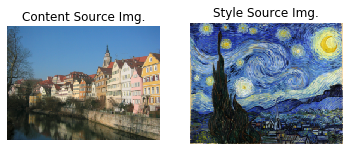

Iteration 0


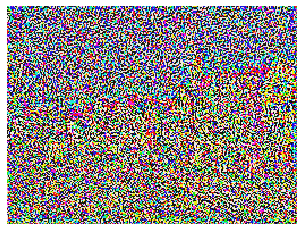

Iteration 100


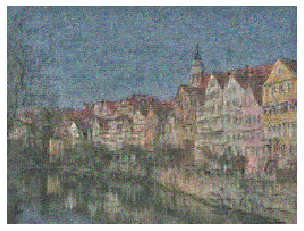

Iteration 199


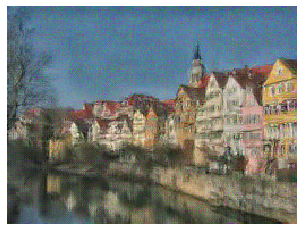

In [17]:
# Feature Inversion -- Starry Night + Tubingen
params_inv = {
    'content_image' : 'styles/tubingen.jpg',
    'style_image' : 'styles/starry_night.jpg',
    'image_size' : 192,
    'style_size' : 192,
    'content_layer' : 3,
    'content_weight' : 6e-2,
    'style_layers' : [1, 4, 6, 7],
    'style_weights' : [0, 0, 0, 0], # we discard any contributions from style to the loss
    'tv_weight' : 2e-2,
    'init_random': True # we want to initialize our image to be random
}

style_transfer(**params_inv)